# Objective
Mobile application with a fruit pictures classifier engine

# Data
Link to upload data: https://www.kaggle.com/moltean/fruits

# Table of contents <a class="anchor" id="chapter0"></a> 
* [Preparation](#chapter1)
    * [Import packages](#sub1_1)
    * [Get picture information](#sub1_2)
    * [Explore picture information](#sub1_3)
    * [Get class information](#sub1_4) 
    * [Target label encoding](#sub1_5)
* [Transform the picture](#chapter2)
    * [Estimate the picture file size](#sub2_1)
    * [Extract the fruit from the background](#sub2_2)
* [Feature engineering](#chapter3)
    * [Generate descriptors on Training dataset](#sub3_1)
    * [Cluster's descriptors](#sub3_2)
    * [Compute frequency histogram on clusters' descriptors](#sub3_3)
    * [Reduce dimension with PCA](#sub3_4)
* [Modelling](#chapter4)
    * [Train a KNN model](#sub4_1)
    * [Check learning curve](#sub4_2)
    * [Predict and compare prediction to reality on Test dataset](#sub4_3)
    * [Predict and compare prediction to reality on Validation dataset](#sub4_4)
* [Go to End](#chapter100)

# Preparation <a class="anchor" id="chapter1"></a>

## Import packages <a class="anchor" id="sub1_1"></a>

In [1]:
import P8_02_module as MyMod

import numpy as np
import pandas as pd 

import os
import glob
import time

import matplotlib.pyplot as plt
from matplotlib.image import imread

from cv2 import cv2
import PIL
from PIL import Image, ImageDraw, ImageOps, ImageFilter

from sklearn import cluster
from sklearn import decomposition
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle

In [2]:
# Sample volume limitations
GET_PICTURES_SAMPLE_SIZE = 5000
TRAINING_SAMPLE_SIZE = 5000
TEST_SAMPLE_SIZE = 5000
VALIDATION_SAMPLE_SIZE = 5000

# KMeans hyper-param
KMEANS_N_CLUSTERS = 90

# Pictures repository
PERSO_REP = "C:\\Users\\BNP Leasing\\3D Objects\\Soutenance P8\\fruits-perso\\"

## Get picture information <a class="anchor" id="sub1_2"></a>

In [3]:
# Get Dataset names, Target class names and Picture names
path = '../fruits-360-original-size/'
df_main = pd.DataFrame(columns = ['FullFileName', 'Dataset' , 'Target', 'Picture', 'FileSize (in KB)']) 
i = 0
for file in glob.iglob(path+'**/*.jpg', recursive = True):
 
    lst = file.split('\\')
    lst.append(np.round(os.path.getsize(file) / 1024, 1))  # in KBytes    
    df_main.loc[len(df_main)] = lst
    
    i += 1
    if i > GET_PICTURES_SAMPLE_SIZE: break

# Build full file names
df_main['FullFileName'] = df_main['FullFileName']+'/'+df_main['Dataset']+'/'+df_main['Target']+'/'+df_main['Picture']  
df_main

,FullFileName,Dataset,Target,Picture,FileSize (in KB)
0,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_103.jpg,15.6
1,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_107.jpg,15.8
2,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_11.jpg,16.2
3,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_111.jpg,15.9
4,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_115.jpg,16.2
...,...,...,...,...,...
4996,../fruits-360-original-size/Training/apple_gra...,Training,apple_granny_smith_1,r0_10.jpg,35.7
4997,../fruits-360-original-size/Training/apple_gra...,Training,apple_granny_smith_1,r0_100.jpg,37.3
4998,../fruits-360-original-size/Training/apple_gra...,Training,apple_granny_smith_1,r0_102.jpg,37.6
4999,../fruits-360-original-size/Training/apple_gra...,Training,apple_granny_smith_1,r0_104.jpg,37.8


## Explore picture information <a class="anchor" id="sub1_3"></a>

### Assess volumes and modalities

In [4]:
df_main.describe()

,FileSize (in KB)
count,5001.000000
mean,42.329494
std,18.712935
min,14.200000
25%,31.300000
50%,37.600000
75%,50.800000
max,122.200000


 > 12 455 pictures, 24 target classes, 3 datasets  
 > 958 picture names mean that some pictures have the same name and are not classified in the same repository

### Count pictures by target class and dataset

In [5]:
pd.DataFrame(df_main.groupby(['Target', 'Dataset'])['Picture'].count())

Picture
Target               Dataset          
apple_6              Test          157
                     Training      315
apple_braeburn_1     Test          160
                     Training      320
apple_crimson_snow_1 Test          159
                     Training      318
apple_golden_1       Test          154
                     Training      308
apple_golden_2       Test          154
                     Training      308
apple_golden_3       Test          158
                     Training      316
apple_granny_smith_1 Test          160
                     Training        6
apple_hit_1          Test          234
apple_pink_lady_1    Test          156
apple_red_1          Test          154
apple_red_2          Test          159
apple_red_3          Test          140
apple_red_delicios_1 Test          150
apple_red_yellow_1   Test          154
apple_rotten_1       Test          159
cabbage_white_1      Test           47
carrot_1             Test           50
cucumber_1           Test           50
cucumber_3           Test           81
eggplant_violet_1    Test           80
pear_1               Test          162
pear_3               Test           72
zucchini_1           Test           80
zucchini_dark_1      Test           80

### Count pictures by target class

In [6]:
pd.DataFrame(df_main.groupby(['Target'])['Picture'].count())

,Picture
Target,
apple_6,472
apple_braeburn_1,480
apple_crimson_snow_1,477
apple_golden_1,462
apple_golden_2,462
apple_golden_3,474
apple_granny_smith_1,166
apple_hit_1,234
apple_pink_lady_1,156


### Count dataset modality by picture name

In [7]:
df_dataset_mod = pd.DataFrame(df_main.groupby(['Picture'])['Dataset'].nunique())
df_dataset_mod.rename(columns={'Dataset':'Dataset_mod'}, inplace=True)
len(df_dataset_mod[df_dataset_mod['Dataset_mod'] > 1])

0

> No file with the same name in the different datasets

### Count target class modality by picture name

In [8]:
df_target_mod = pd.DataFrame(df_main.groupby(['Picture'])['Target'].nunique())
df_target_mod.rename(columns={'Target':'Target_mod'}, inplace=True)
df_target_mod[df_target_mod['Target_mod'] > 1]

,Target_mod
Picture,
r0_0.jpg,7
r0_10.jpg,7
r0_100.jpg,7
r0_102.jpg,7
r0_103.jpg,24
...,...
r1_94.jpg,6
r1_95.jpg,16
r1_96.jpg,6


In [9]:
df_target_mod = df_target_mod.reset_index(drop=False)

In [10]:
pd.DataFrame(df_target_mod.groupby(['Target_mod'])['Picture'].count())

,Picture
Target_mod,
1,79
2,1
3,7
4,4
6,302
7,7
9,1
10,2
13,1


 > many files with the same name in the different target classes   
 > for instance, 156 files have the same name and appear in 24 different target class

In [11]:
df_main[df_main['Picture'] == 'r0_0.jpg'][['Picture', 'Target', 'Dataset']]

,Picture,Target,Dataset
3110,r0_0.jpg,apple_6,Training
3425,r0_0.jpg,apple_braeburn_1,Training
3745,r0_0.jpg,apple_crimson_snow_1,Training
4063,r0_0.jpg,apple_golden_1,Training
4371,r0_0.jpg,apple_golden_2,Training
4679,r0_0.jpg,apple_golden_3,Training
4995,r0_0.jpg,apple_granny_smith_1,Training


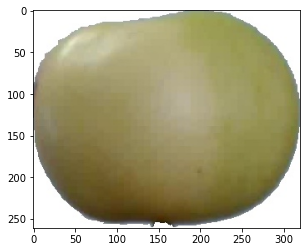

In [12]:
pict = Image.open(df_main['FullFileName'].iloc[3110])
plt.imshow(pict)
plt.show()

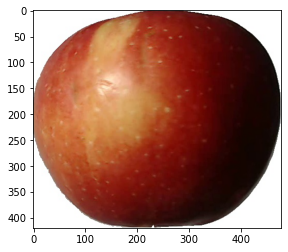

In [13]:
pict = Image.open(df_main['FullFileName'].iloc[3425])
plt.imshow(pict)
plt.show()

 > File name format: r?_image_index.jpg (e.g. r0_31.jpg or r1_12.jpg)  
 > "r?" stands for rotation axis (first one is r0)

### Distinguish rotation axis and index

In [14]:
df_main["Rotation"], df_main["Index"] = df_main["Picture"].str.split("_", 1).str
df_main["Rotation"] = df_main["Rotation"].str.replace('r','')
df_main["Index"] = df_main["Index"].str.replace('.jpg','')
df_main

<ipython-input-14-c3157c8b4a5d>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_main["Rotation"], df_main["Index"] = df_main["Picture"].str.split("_", 1).str
<ipython-input-14-c3157c8b4a5d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_main["Index"] = df_main["Index"].str.replace('.jpg','')


,FullFileName,Dataset,Target,Picture,FileSize (in KB),Rotation,Index
0,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_103.jpg,15.6,0,103
1,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_107.jpg,15.8,0,107
2,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_11.jpg,16.2,0,11
3,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_111.jpg,15.9,0,111
4,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_115.jpg,16.2,0,115
...,...,...,...,...,...,...,...
4996,../fruits-360-original-size/Training/apple_gra...,Training,apple_granny_smith_1,r0_10.jpg,35.7,0,10
4997,../fruits-360-original-size/Training/apple_gra...,Training,apple_granny_smith_1,r0_100.jpg,37.3,0,100
4998,../fruits-360-original-size/Training/apple_gra...,Training,apple_granny_smith_1,r0_102.jpg,37.6,0,102
4999,../fruits-360-original-size/Training/apple_gra...,Training,apple_granny_smith_1,r0_104.jpg,37.8,0,104


In [15]:
pd.DataFrame(df_main["Rotation"].unique())

,0
0,0
1,1
2,2


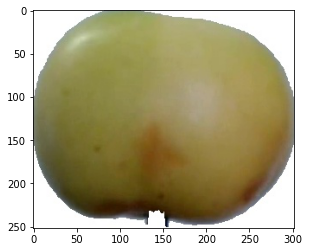

In [16]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '0'].head(1).index[0]])
plt.imshow(pict)
plt.show()

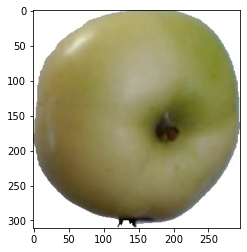

In [17]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '1'].head(1).index[0]])
plt.imshow(pict)
plt.show()

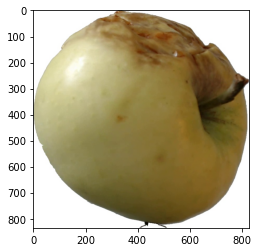

In [18]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '2'].head(1).index[0]])
plt.imshow(pict)
plt.show()

 > 0 - queue top or down > rotation around the z-axis  
 > 1 - queue behind or ahead > rotation around the x-axis  
 > 2 - queue left or right > rotation around the y-axis  

### Target class count distribution

In [19]:
def distribution(df_in, dataset):
    
    df = df_in.copy()
    
    if dataset in ['Training', 'Test', 'Validation']:
        df.drop(df[df['Dataset'] != dataset].index, inplace=True)
    elif dataset != '*':
        print("dataset argument should be 'Training', 'Test', 'Validation' or '*'")
        return -1
        
    df_distrib = pd.DataFrame(df.groupby(['Target'])['Picture'].count())
    df_distrib.reset_index(drop=False, inplace=True)
    df_distrib.rename(columns={'Picture':'Picture count', 'Target':'Class'}, inplace=True)
    df_distrib = df_distrib.sort_values(by='Class', ascending=False)    

    if len(df_distrib) == 0: return -1
    
    df_distrib.plot.barh(x='Class', y='Picture count', figsize=(12, 10))    
    
    return 1

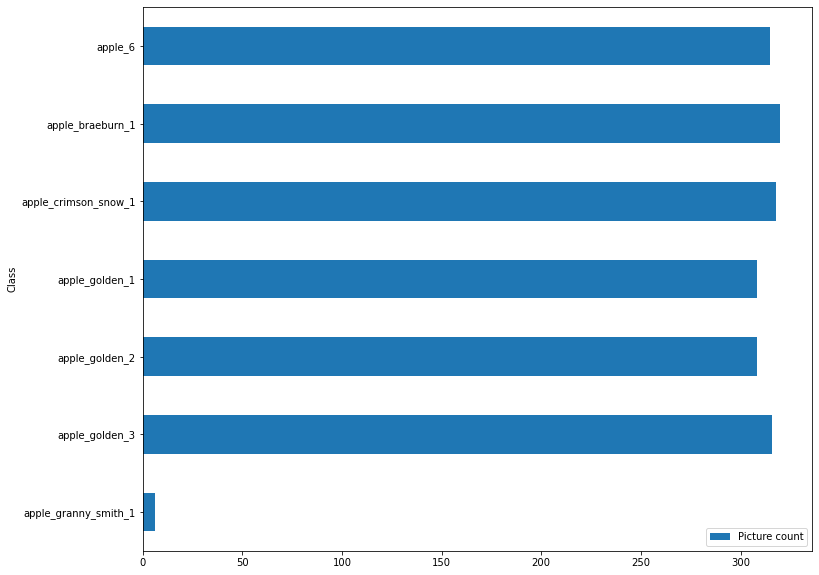

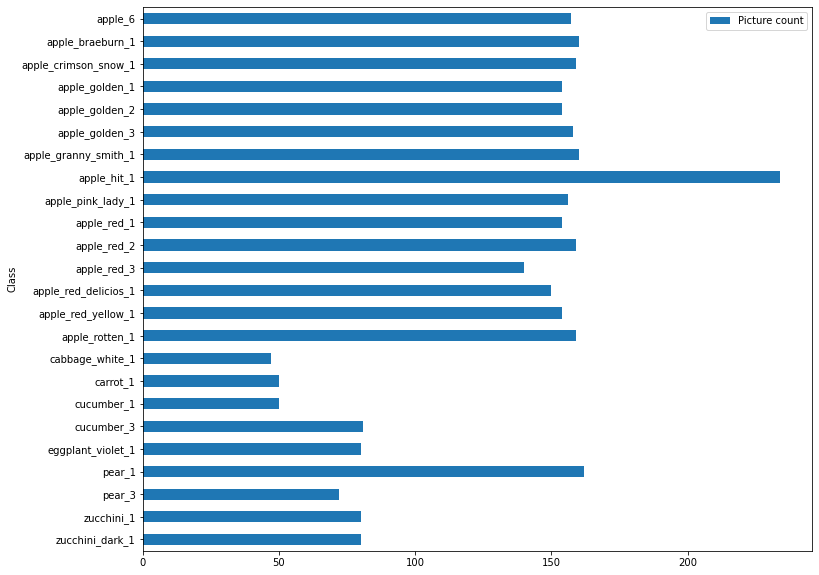

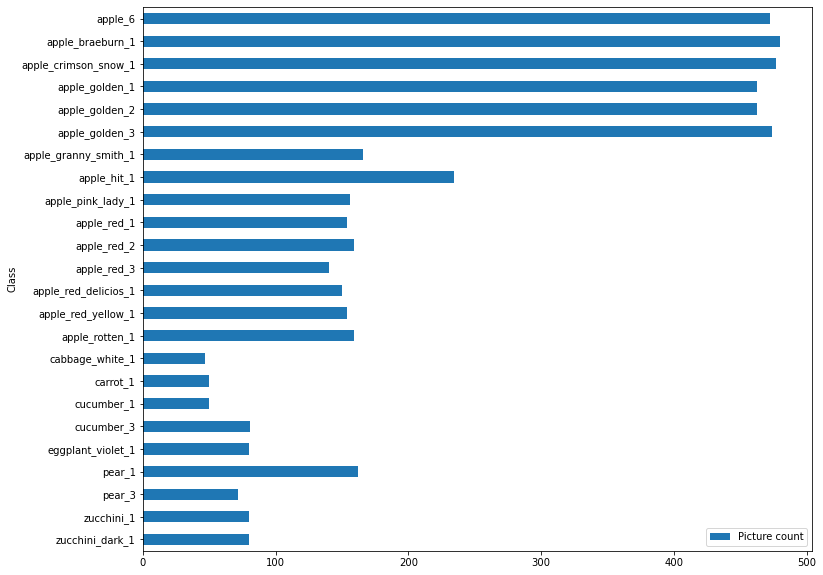

In [20]:
ret = distribution(df_main, 'Training')
ret = distribution(df_main, 'Test')
ret = distribution(df_main, 'Validation')
ret = distribution(df_main, '*')

### Target class filesize average distribution  
Logitech C920 camera and dedicated algorithm which extract the fruit from the background

In [21]:
pd.DataFrame(df_main.groupby('Target')['FileSize (in KB)'].mean())

,FileSize (in KB)
Target,
apple_6,17.409110
apple_braeburn_1,43.060000
apple_crimson_snow_1,57.678826
apple_golden_1,35.083333
apple_golden_2,31.851948
apple_golden_3,32.843460
apple_granny_smith_1,36.820482
apple_hit_1,97.450855
apple_pink_lady_1,36.520513


In [22]:
pd.DataFrame(df_main.groupby('Dataset')['FileSize (in KB)'].mean())

,FileSize (in KB)
Dataset,
Test,45.969453
Training,36.343099


## Get class information <a class="anchor" id="sub1_4"></a>

In [23]:
path = '../fruits-360-original-size/Meta/'

df_class_add = pd.DataFrame(columns = ['PathName', 'Target', 'TxtName'])
df_meta = pd.DataFrame(columns = ['Flag', 'Value'])

for file in glob.iglob(path+'**/info.txt', recursive = True):
    
    df_meta_add = pd.read_csv(file, sep="=", names=['Flag', 'Value'])
        
    df_class_add.loc[0] = file.split('\\')   
        
    df_meta = pd.concat([df_class_add.join(df_meta_add, how='cross'), df_meta])

del df_class_add, df_meta_add

df_meta.drop(columns=['PathName', 'TxtName'], inplace=True)
df_meta = df_meta.sort_values(['Target', 'Flag'], ascending=True)
df_meta.reset_index(drop=True, inplace=True)
df_meta

,Target,Flag,Value
0,apple_6,CLUSTERS[2],0
1,apple_6,DEFECTS[2],0
2,apple_6,FAT[3],0
3,apple_6,FRUCTOSE[3],2
4,apple_6,GROWTH LOCATION[3],2
...,...,...,...
403,zucchini_dark_1,SKIN ROUGHNESS[2],0
404,zucchini_dark_1,TYPE[5],1
405,zucchini_dark_1,VERSION,2021.09.10.0
406,zucchini_dark_1,WATER[3],2


In [24]:
df_meta['Flag'].nunique()

18

In [25]:
pd.DataFrame(df_meta['Flag'].unique(), columns=['Flag']).sort_values(by='Flag')

,Flag
0,CLUSTERS[2]
1,DEFECTS[2]
2,FAT[3]
3,FRUCTOSE[3]
4,GROWTH LOCATION[3]
5,HARDNESS[3]
6,MATURITY[3]
7,NUMBER OF SEEDS[4]
8,PROCESSED[2]
9,PURCHASED[2]


## Target label encoding  <a class="anchor" id="sub1_5"></a>

In [26]:
df_main, df_target_mapping = MyMod.encode_LabelEncoder(df_main, 'Target')
df_main.head(5)

,FullFileName,Dataset,Target,Picture,FileSize (in KB),Rotation,Index,Target_encoded
0,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_103.jpg,15.6,0,103,0
1,../fruits-360-original-size/Test/apple_6/r0_10...,Test,apple_6,r0_107.jpg,15.8,0,107,0
2,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_11.jpg,16.2,0,11,0
3,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_111.jpg,15.9,0,111,0
4,../fruits-360-original-size/Test/apple_6/r0_11...,Test,apple_6,r0_115.jpg,16.2,0,115,0


In [27]:
df_meta, df_target_mapping = MyMod.encode_LabelEncoder(df_meta, 'Target')
df_meta.head(5)

,Target,Flag,Value,Target_encoded
0,apple_6,CLUSTERS[2],0,0
1,apple_6,DEFECTS[2],0,0
2,apple_6,FAT[3],0,0
3,apple_6,FRUCTOSE[3],2,0
4,apple_6,GROWTH LOCATION[3],2,0


In [28]:
df_target_mapping

,Target
Target_encoded,
0,apple_6
1,apple_braeburn_1
2,apple_crimson_snow_1
3,apple_golden_1
4,apple_golden_2
5,apple_golden_3
6,apple_granny_smith_1
7,apple_hit_1
8,apple_pink_lady_1


# Transform the picture  <a class="anchor" id="chapter2"></a>

## Estimate the initial picture file size  <a class="anchor" id="sub2_1"></a>
With my One plus pro : 3 photos 7.8 MB > 2.6 MB in average 

In [29]:
print(np.round(os.path.getsize(PERSO_REP+"IMG_20220220_153220.jpg") / 1024**2, 1))
print(np.round(os.path.getsize(PERSO_REP+"IMG_20220220_153246.jpg") / 1024**2, 1))
print(np.round(os.path.getsize(PERSO_REP+"IMG_20220220_153233.jpg") / 1024**2, 1))

3.8
2.2
1.7


## Extract the foreground <a class="anchor" id="sub2_2"></a>

### Flood fill type algorithm which extract the fruit from the background  ?

In [30]:
'''img = Image.open(PERSO_REP+"IMG_20220220_153220.jpg")

# Converting the image to RGB mode
img1 = img.convert("RGB")

# Coordinates of the pixel whose value would be used as seed
seed = (0, 0)

# Pixel Value which would be used for replacement
rep_value = (255, 255, 255)

# Calling the floodfill() function and passing it image, seed, value and thresh as arguments
ImageDraw.floodfill(img1, seed, rep_value, thresh=10)

# Displaying the image
img1.show()

#print(np.round(os.path.getsize(PERSO_REP+"IMG_20220220_153220.jpg") / 1024**2, 1))'''

'img = Image.open(PERSO_REP+"IMG_20220220_153220.jpg")\n\n# Converting the image to RGB mode\nimg1 = img.convert("RGB")\n\n# Coordinates of the pixel whose value would be used as seed\nseed = (0, 0)\n\n# Pixel Value which would be used for replacement\nrep_value = (255, 255, 255)\n\n# Calling the floodfill() function and passing it image, seed, value and thresh as arguments\nImageDraw.floodfill(img1, seed, rep_value, thresh=10)\n\n# Displaying the image\nimg1.show()\n\n#print(np.round(os.path.getsize(PERSO_REP+"IMG_20220220_153220.jpg") / 1024**2, 1))'

In [31]:
'''import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread(PERSO_REP+"IMG_20220220_153220.jpg")

mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (30,20,150,200)

cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img)
plt.colorbar()
plt.show()'''

'import numpy as np\nimport cv2\nfrom matplotlib import pyplot as plt\n\nimg = cv2.imread(PERSO_REP+"IMG_20220220_153220.jpg")\n\nmask = np.zeros(img.shape[:2],np.uint8)\n\nbgdModel = np.zeros((1,65),np.float64)\nfgdModel = np.zeros((1,65),np.float64)\n\nrect = (30,20,150,200)\n\ncv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)\nmask2 = np.where((mask==2)|(mask==0),0,1).astype(\'uint8\')\nimg = img*mask2[:,:,np.newaxis]\n\nplt.imshow(img)\nplt.colorbar()\nplt.show()'

### Correct exposition  ?
### Supprimer le bruit avec un filtre Gaussien
pict = pict.filter(ImageFilter.GaussianBlur(radius=2))
plt.imshow(pict)
plt.show()

### Corriger l'exposition : Etirer l'histogramme
pict = ImageOps.autocontrast(pict, cutoff=0, ignore=None, mask=None, preserve_tone=False)
plt.imshow(pict)
plt.show()

### Corriger le contraste : Egaliser l'histogramme
pict = ImageOps.equalize(pict, mask=None)
plt.imshow(pict)
plt.show()

# Feature engineering <a class="anchor" id="chapter3"></a> 

## Generate descriptors on Training dataset <a class="anchor" id="sub3_1"></a>

In [32]:
def dataset_reduction(df, SAMPLE_SIZE):
    # Initiate index
    ind_sample = np.arange(len(df))
    # Shuffle
    ind_sample = shuffle(ind_sample, random_state=42)
    # Select SAMPLE_SIZE first index  
    ind_sample = ind_sample[:TRAINING_SAMPLE_SIZE]
    
    # Check balanced dataset over 'Target', 'Rotation' features
    # Prepare resulting dataframe
    df_ret = df.iloc[ind_sample] 
    # Reset index
    df_ret.reset_index(drop=True, inplace=True)
    
    return df_ret

df_main_training = df_main[df_main['Dataset'] == 'Training']
df_main_training = dataset_reduction(df_main_training, TRAINING_SAMPLE_SIZE)
df_main_training

,FullFileName,Dataset,Target,Picture,FileSize (in KB),Rotation,Index,Target_encoded
0,../fruits-360-original-size/Training/apple_gol...,Training,apple_golden_3,r1_254.jpg,33.8,1,254,5
1,../fruits-360-original-size/Training/apple_gol...,Training,apple_golden_1,r0_280.jpg,28.8,0,280,3
2,../fruits-360-original-size/Training/apple_6/r...,Training,apple_6,r0_56.jpg,15.7,0,56,0
3,../fruits-360-original-size/Training/apple_gol...,Training,apple_golden_3,r1_110.jpg,31.3,1,110,5
4,../fruits-360-original-size/Training/apple_gol...,Training,apple_golden_2,r0_104.jpg,32.4,0,104,4
...,...,...,...,...,...,...,...,...
1886,../fruits-360-original-size/Training/apple_gol...,Training,apple_golden_1,r1_14.jpg,33.1,1,14,3
1887,../fruits-360-original-size/Training/apple_gol...,Training,apple_golden_2,r0_158.jpg,31.0,0,158,4
1888,../fruits-360-original-size/Training/apple_cri...,Training,apple_crimson_snow_1,r1_218.jpg,64.9,1,218,2
1889,../fruits-360-original-size/Training/apple_gol...,Training,apple_golden_2,r1_178.jpg,34.4,1,178,4


In [33]:
def desc_extraction(df_main_training):
    
    # Create SIFT descriptor
    sift = cv2.SIFT_create()

    # Initiate the resulting dataframe for key points descriptors
    df_kpdesc_training = pd.DataFrame()

    for pict_num in range(len(df_main_training)):

        # Print treatment progress each 100 pictures
        if pict_num%100 == 0 : print(pict_num)

        # Open the picture
        pict = Image.open(df_main_training['FullFileName'].iloc[pict_num])

        # Compute key points and picture descriptors
        # descript: numpy array with one line by interest point, 128 columns
        keypoints, descript = sift.detectAndCompute(np.array(pict), None)

        # Enrich df_kpdesc_training with FullFileName
        df_pict_name = df_main_training[df_main_training.index == pict_num][['FullFileName']]        
        df_kpdesc = df_pict_name.merge(pd.DataFrame(descript), how='cross')

        # Concatenate new samples to the resulting dataframe
        df_kpdesc_training = pd.concat([df_kpdesc_training, df_kpdesc])

    # Reset indexation
    df_kpdesc_training.reset_index(drop=True, inplace=True)
    
    return df_kpdesc_training

In [34]:
# Save starting time
time_start=time.time()

df_kpdesc_training = desc_extraction(df_main_training)

# Compute time elapse
elapse_s = round(time.time()-time_start, 0)
elapse_m = round(elapse_s / 60, 2)
print()
print('Time elapse with SIFT descriptor : {} seconds ({} minutes)'.format(elapse_s, elapse_m))

print()
print("Descriptor dataframe shape : ", df_kpdesc_training.shape)

df_kpdesc_training.head(5)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800

Time elapse with SIFT descriptor : 96.0 seconds (1.6 minutes)

Descriptor dataframe shape :  (258837, 129)


,FullFileName,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,../fruits-360-original-size/Training/apple_gol...,21.0,114.0,58.0,6.0,13.0,9.0,2.0,1.0,143.0,...,0.0,1.0,2.0,2.0,0.0,1.0,1.0,9.0,4.0,0.0
1,../fruits-360-original-size/Training/apple_gol...,3.0,12.0,10.0,7.0,6.0,7.0,0.0,0.0,151.0,...,0.0,11.0,25.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0
2,../fruits-360-original-size/Training/apple_gol...,11.0,0.0,0.0,12.0,122.0,7.0,1.0,7.0,147.0,...,46.0,11.0,0.0,0.0,7.0,4.0,1.0,15.0,4.0,0.0
3,../fruits-360-original-size/Training/apple_gol...,0.0,1.0,2.0,5.0,21.0,51.0,9.0,1.0,165.0,...,0.0,88.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,../fruits-360-original-size/Training/apple_gol...,7.0,43.0,13.0,1.0,3.0,10.0,8.0,3.0,105.0,...,1.0,179.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0


## Clusters' descriptors <a class="anchor" id="sub3_2"></a>

In [35]:
# Save starting time
time_start = time.time()

# Create KMeans clustering model
kmeans = cluster.KMeans(n_clusters=KMEANS_N_CLUSTERS, random_state=42) 

# Train and predict using KMeans clustering model
df_kpdesc_training = pd.concat([df_kpdesc_training, \
    pd.DataFrame(kmeans.fit_predict(df_kpdesc_training[df_kpdesc_training.columns[1:]].values), \
                 columns=['Desc_cluster'])], axis=1)

# Compute time elapse
elapse_s = time.time()-time_start
elapse_m = int(elapse_s / 60)
print('KMeans {} clusters done! Time elapsed: {} seconds ({} minutes)'.format(KMEANS_N_CLUSTERS, elapse_s, elapse_m))

# Number of iterations run et Coordinates of cluster centers
print("Case {} clusters: Converge after {} iterations"\
      .format(kmeans.cluster_centers_.shape[0], kmeans.n_iter_)) 

print()
print("Descriptor dataframe shape : ", df_kpdesc_training.shape)

df_kpdesc_training

KMeans 90 clusters done! Time elapsed: 519.2014083862305 seconds (8 minutes)
Case 90 clusters: Converge after 300 iterations

Descriptor dataframe shape :  (258837, 130)


,FullFileName,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,Desc_cluster
0,../fruits-360-original-size/Training/apple_gol...,21.0,114.0,58.0,6.0,13.0,9.0,2.0,1.0,143.0,...,1.0,2.0,2.0,0.0,1.0,1.0,9.0,4.0,0.0,45
1,../fruits-360-original-size/Training/apple_gol...,3.0,12.0,10.0,7.0,6.0,7.0,0.0,0.0,151.0,...,11.0,25.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,76
2,../fruits-360-original-size/Training/apple_gol...,11.0,0.0,0.0,12.0,122.0,7.0,1.0,7.0,147.0,...,11.0,0.0,0.0,7.0,4.0,1.0,15.0,4.0,0.0,59
3,../fruits-360-original-size/Training/apple_gol...,0.0,1.0,2.0,5.0,21.0,51.0,9.0,1.0,165.0,...,88.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,41
4,../fruits-360-original-size/Training/apple_gol...,7.0,43.0,13.0,1.0,3.0,10.0,8.0,3.0,105.0,...,179.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258832,../fruits-360-original-size/Training/apple_gol...,2.0,1.0,126.0,126.0,2.0,1.0,9.0,26.0,5.0,...,57.0,4.0,0.0,0.0,0.0,0.0,1.0,15.0,66.0,8
258833,../fruits-360-original-size/Training/apple_gol...,0.0,1.0,29.0,46.0,1.0,0.0,0.0,0.0,0.0,...,24.0,1.0,9.0,53.0,21.0,1.0,4.0,92.0,3.0,71
258834,../fruits-360-original-size/Training/apple_gol...,57.0,133.0,2.0,0.0,6.0,9.0,0.0,0.0,12.0,...,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,42
258835,../fruits-360-original-size/Training/apple_gol...,30.0,154.0,95.0,4.0,0.0,1.0,4.0,4.0,103.0,...,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


## Compute frequency histogram on clusters' descriptors <a class="anchor" id="sub3_3"></a>
samples: pictures x features: clusters

In [36]:
def histo_freq(df_kpdesc_training):
    
    # Use index to count
    df_kpdesc_training.reset_index(drop=False, inplace=True)
    df_kpdesc_training = df_kpdesc_training.pivot_table('index', index='FullFileName', columns='Desc_cluster', \
                                                        aggfunc='count', fill_value=0, margins=True)
    # Normalise: total for a picture is one
    for c in df_kpdesc_training.columns[:-1]:
        df_kpdesc_training[c] = df_kpdesc_training[c] / df_kpdesc_training['All']

    # Drop unusefull information
    df_kpdesc_training.drop(index='All', inplace=True)
    df_kpdesc_training.drop(columns='All', inplace=True)
    return df_kpdesc_training
    
df_kpdesc_training = histo_freq(df_kpdesc_training)    

## Reduce dimension with PCA <a class="anchor" id="sub3_4"></a>

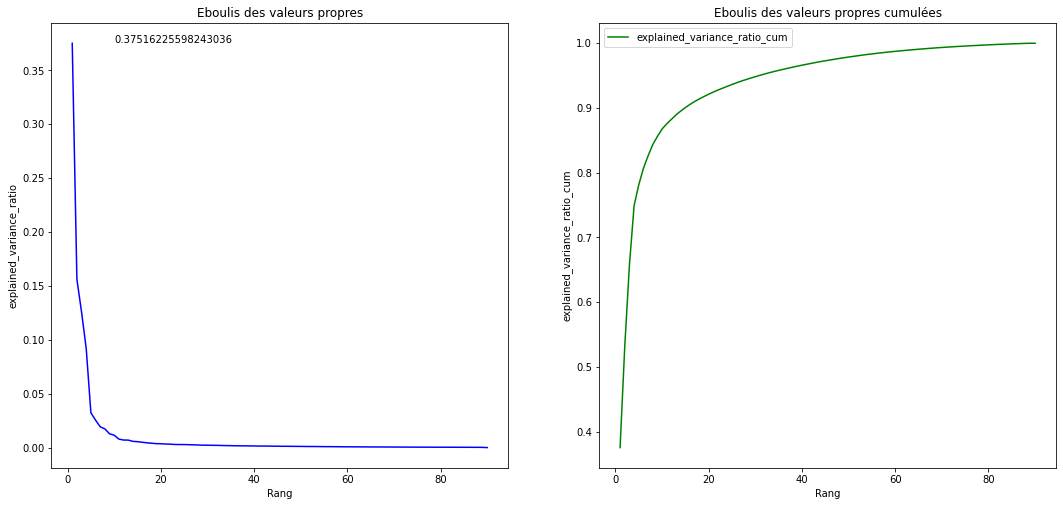

15 clusters explain 90.0% of the variance


In [37]:
PCA_N_COMPONENTS = 0.90

# Create PCA 
pca = decomposition.PCA()

# Fit PCA
pca.fit(df_kpdesc_training.values)

# Draw explained variance absolute and cumulated
df_eboulis = MyMod.graph_eboulis_valeurspropres(pca, (18, 18), True)

print("{} clusters explain {}% of the variance"\
           .format(df_eboulis[df_eboulis['explained_variance_ratio_cum'] > PCA_N_COMPONENTS]['rang'].min(), \
                   PCA_N_COMPONENTS * 100))

In [38]:
# Create PCA 
pca = decomposition.PCA(n_components=PCA_N_COMPONENTS)

# Fit Transform PCA
pict_features = pca.fit_transform(df_kpdesc_training.values)

print()
print("Matrix dimensions (pictures, visual words) : {}".format(pict_features.shape)) 

# Get PC coordinates in cluster space
df_contrib_PC = pd.DataFrame(pca.components_, columns=df_kpdesc_training.columns) 
df_contrib_PC.shape 

# Get the cluster best represented for each PC
#df_contrib_PC_t = df_contrib_PC.transpose()
lst_contrib = []
for i in range(pca.n_components_):     
    lst_contrib.append(df_contrib_PC.transpose()[i].idxmax(axis=0))
    
# Keep only the cluster best represented
df_kpdesc_training = df_kpdesc_training[lst_contrib]
del lst_contrib

# Unduplicate identical columns
df_kpdesc_training = df_kpdesc_training.T.groupby(level=0).first().T

df_kpdesc_training.head(5)


Matrix dimensions (pictures, visual words) : (1891, 15)


Desc_cluster,0,4,8,9,17,30,41,49,53,67,69,76
FullFileName,,,,,,,,,,,,
../fruits-360-original-size/Training/apple_6/r0_0.jpg,0.076923,0.153846,0.0,0.0,0.0,0.038462,0.192308,0.000000,0.076923,0.000000,0.0,0.076923
../fruits-360-original-size/Training/apple_6/r0_10.jpg,0.000000,0.153846,0.0,0.0,0.0,0.000000,0.076923,0.000000,0.076923,0.000000,0.0,0.230769
../fruits-360-original-size/Training/apple_6/r0_100.jpg,0.035714,0.107143,0.0,0.0,0.0,0.000000,0.107143,0.035714,0.142857,0.107143,0.0,0.071429
../fruits-360-original-size/Training/apple_6/r0_102.jpg,0.043478,0.086957,0.0,0.0,0.0,0.000000,0.043478,0.217391,0.043478,0.000000,0.0,0.043478
../fruits-360-original-size/Training/apple_6/r0_104.jpg,0.071429,0.142857,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.285714,0.000000,0.0,0.000000


# Modelling <a class="anchor" id="chapter4"></a> 

## Train a KNN model <a class="anchor" id="sub4_1"></a>

In [39]:
# Create KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train KNN model
X_train = df_kpdesc_training.values
y_train = df_main_training['Target_encoded'].values
knn.fit(X_train, y_train)

KNeighborsClassifier()

## Check learning curve <a class="anchor" id="sub4_2"></a>

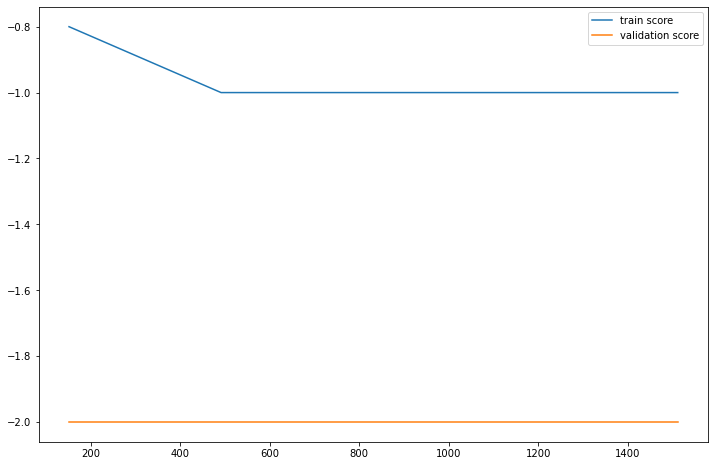

In [40]:
train_sizes_abs, train_scores, test_scores = learning_curve(knn, X_train, y_train, 
                                            cv=5, scoring='neg_median_absolute_error',
                                            train_sizes=np.linspace(0.1, 1, 5), 
                                            random_state=42)
plot = plt.figure(figsize=(12, 8))
plot = plt.plot(train_sizes_abs, train_scores.mean(axis=1), label='train score')
plot = plt.plot(train_sizes_abs, test_scores.mean(axis=1), label='validation score')
plot = plt.legend()

## Predict and compare prediction to reality on Test dataset <a class="anchor" id="sub4_3"></a>

In [41]:
def predict_class(df, kmeans_model, pca_col_lst, knn_model):
    
    # Save starting time
    time_start = time.time()

    # Extract descriptors
    df_kpdesc = desc_extraction(df)

    # Predict clusters' descriptors with KMEANS
    df_kpdesc = pd.concat([df_kpdesc, \
        pd.DataFrame(kmeans.predict(df_kpdesc[df_kpdesc.columns[1:]].values), columns=['Desc_cluster'])], axis=1)

    # Compute histogram for main clusters
    df_kpdesc = histo_freq(df_kpdesc)    
    df_kpdesc = df_kpdesc[pca_col_lst]

    # Predict class with trained KNN
    df = pd.concat([df, pd.DataFrame(knn.predict(df_kpdesc.values), columns=['Predict'])], axis=1)

    # Compute time elapse
    elapse_s = time.time()-time_start
    elapse_m = int(elapse_s / 60)
    print('Test predictions done! Time elapsed: {} seconds ({} minutes)'.format(elapse_s, elapse_m))
    
    # Assess result ARI
    ari = metrics.adjusted_rand_score(df['Target_encoded'].values, df['Predict'].values)
    print('Test predictions done! Adjusted Rand Index: {}'.format(ari))
    
    return df

# Select Test dataset
df_main_test = df_main[df_main['Dataset'] == 'Test']
df_main_test = dataset_reduction(df_main_test, TEST_SAMPLE_SIZE)

# Predict on Test dataset
df_main_test = predict_class(df_main_test, kmeans, df_kpdesc_training.columns, knn)
df_main_test.head(5)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
Test predictions done! Time elapsed: 234.34033799171448 seconds (3 minutes)
Test predictions done! Adjusted Rand Index: -0.0003951048154704418


,FullFileName,Dataset,Target,Picture,FileSize (in KB),Rotation,Index,Target_encoded,Predict
0,../fruits-360-original-size/Test/apple_golden_...,Test,apple_golden_2,r0_51.jpg,31.6,0,51,4,3
1,../fruits-360-original-size/Test/apple_red_2/r...,Test,apple_red_2,r1_147.jpg,37.3,1,147,10,1
2,../fruits-360-original-size/Test/apple_braebur...,Test,apple_braeburn_1,r0_307.jpg,42.1,0,307,1,4
3,../fruits-360-original-size/Test/pear_3/r0_11.jpg,Test,pear_3,r0_11.jpg,73.0,0,11,21,3
4,../fruits-360-original-size/Test/apple_braebur...,Test,apple_braeburn_1,r0_319.jpg,42.6,0,319,1,3


## Predict and compare prediction to reality on Validation dataset <a class="anchor" id="sub4_4"></a>

In [42]:
# Select Validation dataset
df_main_validation = df_main[df_main['Dataset'] == 'Validation']
df_main_validation = dataset_reduction(df_main_validation, VALIDATION_SAMPLE_SIZE)

# Predict on Validation dataset
df_main_validation = predict_class(df_main_validation, kmeans, df_kpdesc_training.columns, knn)
df_main_validation.head(5)

ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required.

* [Go to Table des matières](#chapter0)

# End <a class="anchor" id="chapter100"></a> 

In [ ]:
'''df_main: FullFileName, Dataset, Target, Picture, FileSize (in KB), Rotation, Index, Target_encoded
df_meta: Target, Flag, Value, Target_encoded
df_target_mapping: Target_encoded, Target

df_main_training, df_main_test, df_main_validation: 
        FullFileName, Dataset, Target, Picture, FileSize (in KB), Rotation, Index, Target_encoded, Predict
df_kpdesc_training: FullFileName, Desc_cluster'''

In [43]:
df_target_mapping

,Target
Target_encoded,
0,apple_6
1,apple_braeburn_1
2,apple_crimson_snow_1
3,apple_golden_1
4,apple_golden_2
5,apple_golden_3
6,apple_granny_smith_1
7,apple_hit_1
8,apple_pink_lady_1


In [44]:
df_meta

,Target,Flag,Value,Target_encoded
0,apple_6,CLUSTERS[2],0,0
1,apple_6,DEFECTS[2],0,0
2,apple_6,FAT[3],0,0
3,apple_6,FRUCTOSE[3],2,0
4,apple_6,GROWTH LOCATION[3],2,0
...,...,...,...,...
403,zucchini_dark_1,SKIN ROUGHNESS[2],0,23
404,zucchini_dark_1,TYPE[5],1,23
405,zucchini_dark_1,VERSION,2021.09.10.0,23
406,zucchini_dark_1,WATER[3],2,23
